# held out disease experiment

Eval of how it performs on unseen diseases

For each study s_i 

1. Remove all sentences for study s_i  from the training  set.  
2. Fit model to training set 
3. Strip all sentence for any study which is not s_i from test set
4. Fit & predict held out study

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer
from datetime import datetime, timedelta
import gensim
import negation_data


data_root_folder = 'data'
data_raw_folder = data_root_folder + '/raw'
data_processed_folder = data_root_folder + '/processed'
data_cached_folder= data_root_folder + '/cached'
datasets_folder = data_root_folder + '/datasets'
results_folder='data/results/withheld_disease_eval'

import keras.backend as K

dtype='float16'
K.set_floatx(dtype)

# default is 1e-7 which is too small for float16.  Without adjusting the epsilon, we will get NaN predictions because of divide by zero problems
K.set_epsilon(1e-4) 


# hyper params chosen when producing the datasets
embedding_dimension=300 # size of token vectors
max_document_length=300 # truncate sentences longer than this
num_token_types = 71333 # magic number, it is determined by the tokeniser used to produce the dataset eg
disease_phrase_keep_rate=.5 # likelihood we will drop the disease phrase when training
#tokeniser=get_tokeniser('negation_detection_sentences_experiment_%s_train.txt' % experiment)
#num_token_types=len(tokeniser.word_index)

# 8=referral
# 9=primary
number_of_classes=4
window_before_diagnosis=8
window_after_diagnosis=0
dataset='test' # dev or test
model_name='cnn_flat'
experiment='pri_ref'

# these labels match https://hhsrvmlr1.rvc.ac.uk:8888/notebooks/fp/False%20positives%20-%20CNN%20-%20Dataset%20production.ipynb
class_labels={
    0: '1-never diagnosed',
    1: '2-prior to diagnostic window',
    2: '3-after diagnostic window',
    3: '4-during diagnostic window'}

/home/noel/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load persisted datasets
def load_word2vec_new():
    return gensim.models.KeyedVectors.load_word2vec_format('data/processed/vec_sg_20180321.txt', binary=False, unicode_errors='ignore')

def load_dataset(experiment=8,dataset='train',number_of_classes=4,window_before_diagnosis=8,window_after_diagnosis=0):
    import json
    
    x_1=np.load(datasets_folder+'/x_%s_1_exp_%s.npy' % (dataset,experiment))
    x_2=np.load(datasets_folder+'/x_%s_2_exp_%s.npy' % (dataset,experiment))
    y=np.load(datasets_folder+'/y_%s_exp_%s_classes_%s_window_before_diagnosis_%s_window_after_diagnosis_%s.npy' % 
            (dataset,experiment,number_of_classes,window_before_diagnosis,window_after_diagnosis))
    with open(datasets_folder+'/study_sentence_dictionary_%s_exp_%s.json' % (dataset, experiment)) as f:
        study_sentence_dictionary = json.load(f)
        return x_1,x_2,y,study_sentence_dictionary

def get_tokeniser():
    def get_sentences_generator():
        df=pd.read_csv(data_processed_folder + '/' + 'negation_detection_sentences_experiment_8_train.txt', sep=',',header=0)
    
        for index, row in df.iterrows():
            StudyId,PatientID,NoteID,CaseLabel,Sublabel,SentenceLabel,DiagnosisDate,SourceNoteRecordedDate,Sentence = row
            yield Sentence
        df=pd.read_csv(data_processed_folder + '/' + 'negation_detection_sentences_experiment_9_train.txt', sep=',',header=0)
    
        for index, row in df.iterrows():
            StudyId,PatientID,NoteID,CaseLabel,Sublabel,SentenceLabel,DiagnosisDate,SourceNoteRecordedDate,Sentence = row
            yield Sentence
    tokeniser=Tokenizer()
    tokeniser.fit_on_texts(get_sentences_generator())
    return tokeniser



def merge_datasets(exp_8,exp_9):
    # stack x,x_2, and y
    stacks= [np.vstack([exp_8[i],exp_9[i]]) for i in range(0,3)]
    
    # now merge study_sentence_dictionary.  order is preserved, but index of exp_9 sentences is now at an offset
    study_sentence_dictionary_1, study_sentence_dictionary_2=exp_8[3],exp_9[3]
    offset=len(study_sentence_dictionary_1)
    
    merged_study_sentence_dictionary = study_sentence_dictionary_1.copy()
    
    for studyid,original_indices in study_sentence_dictionary_2.items():
        merged_study_sentence_dictionary[studyid]=[original_index + offset for original_index in original_indices]
        
        
    return (stacks[0],stacks[1],stacks[2],merged_study_sentence_dictionary)







In [3]:
tokeniser=get_tokeniser()

x_train,x_train_2,y_train,study_sentence_dictionary_train=merge_datasets(
                            load_dataset(8,'train',number_of_classes,window_before_diagnosis,window_after_diagnosis)
                            ,load_dataset(9,'train',number_of_classes,window_before_diagnosis,window_after_diagnosis)
                            )
x_dev,x_dev_2,y_dev,study_sentence_dictionary_dev=merge_datasets(
                            load_dataset(8,dataset,number_of_classes,window_before_diagnosis,window_after_diagnosis)
                            ,load_dataset(9,dataset,number_of_classes,window_before_diagnosis,window_after_diagnosis)
                            )

sg=load_word2vec_new() # needed because persisted datasets are in embedding (integer) format

/home/noel/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [4]:
sum(y_dev)

array([24037,  2267, 38486,   344])

In [5]:
def auc(y_test,y_pred):
    import sklearn.metrics
    return sklearn.metrics.roc_auc_score(y_test,y_pred)

def roc(y_test,y_pred, title='Receiver Operating Characteristic'):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.xlabel('1-Specificity (False Positive Rate)')
    plt.show()

def specificity(y_true, y_pred):
    import keras.backend as K 

    # from https://github.com/fchollet/keras/blob/master/keras/metrics.py : matthews_correlation

    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)

    return tn / (tn + fp)

def sensitivity(y_true, y_pred):
    import keras.backend as K 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + 1e-07)
    return recall

def ppv(y_true, y_pred):
    import keras.backend as K 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + 1e-07)
    return precision

from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import label_ranking_average_precision_score, average_precision_score
from itertools import cycle

def evaluate(y_true, y_pred, plot=True, title='Receiver operating characteristic'):
    
    # first drop any classes without an example in the true labels, AUC is undefined in this case
    num_classes=y_true.shape[1]
    drop_classes=list()
    for i in range(0,num_classes):
        # guard no positive examples, skip them as AUC is undefined in this case
        if sum(y_true[:, i]) == 0:
            drop_classes.append(i)
            
    y_true=np.delete(y_true,drop_classes,axis=1)
    y_pred=np.delete(y_pred,drop_classes,axis=1)
    
    if(len(drop_classes)!=0):
        print('dropped %s classes because there were no positive examples in labels (ROC undefined in this case)' % len(drop_classes))
    num_classes=y_true.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= num_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    if plot:
        # Plot all ROC curves
        plt.figure()
        lw = 2
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green'])
        for i, color in zip(range(num_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='{0} area={1:0.2f}'
                     ''.format(class_labels[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.show()
    return roc_auc
    
    
    

In [6]:
def make_model_2(x_train, x_train_2,y_train,word2vec
                 ,filter_sizes=(3,4,5)
                 , num_filters=200
                 , dropout_prob=0.2
                 , hidden_dims=20
                 , pool_size=21
                 , optimizer=keras.optimizers.Adam(), gpu_model=True):
    from keras.models import Sequential, Model
    from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding, Lambda,RepeatVector, Multiply
    from keras.layers.merge import Concatenate
    from keras.preprocessing import sequence
    from keras import regularizers
    from keras.utils import multi_gpu_model
    from keras import regularizers


    # fix random seed
    np.random.seed(42)

    # Training parameters
    num_classes=y_train.shape[1]
    (example_count,sequence_length) = x_train.shape
    
    # set up the embedding layer using the pre-trained word2vec tokens
    embedding_layer=Embedding(num_token_types+1,embedding_dimension, input_length=max_document_length,trainable=False)

    # set weights to the pretrained word2vec
    embedding_matrix=np.zeros((num_token_types+1,embedding_dimension),dtype=dtype)
    for word,i in tokeniser.word_index.items():
        # hopefully not too many missing tokens
        if word not in word2vec:
            continue 
        embedding_vector=word2vec[word]
        embedding_matrix[i]=embedding_vector

    # this model has 2 inputs: the token integers, and the binary feature vector
    
    # input 1
    main_input = Input(shape=(max_document_length,), dtype='int32',name='main_input')
    
    # input 2
    aux_input = Input(shape=(max_document_length,1),dtype=dtype,name='aux_input')
    
    
    z = main_input

    # convert token integers to word embeddings
    z = embedding_layer(z)
    
    # zip the disease phrase indicator feature
    z = keras.layers.concatenate([z, aux_input],axis=2)
    
    conv_blocks = []
    for sz in filter_sizes:
        conv = Convolution1D(filters=num_filters,
                             kernel_size=sz,
                             padding="valid",
                             activation="relu",
                             strides=1)(z)
        conv = MaxPooling1D(pool_size=pool_size)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)
    z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    z = Dropout(dropout_prob)(z)
    z = Dense(hidden_dims, activation="relu",kernel_regularizer=regularizers.l2(0.01))(z)
    model_output = Dense(num_classes, activation="softmax")(z)

    if gpu_model == True:
        with tf.device('/cpu:0'):
            cpu_model = Model(inputs=[main_input,aux_input],outputs=[model_output]) 
            embedding_layer.set_weights([embedding_matrix.astype(dtype)])
            parallel_model = multi_gpu_model(cpu_model, gpus=2)
            parallel_model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])#,specificity,sensitivity, ppv])
            print(cpu_model.summary())
            return (cpu_model, parallel_model,embedding_layer) # cpu model needed to save model
    else:
        model = Model(inputs=[main_input,aux_input],outputs=[model_output])
        model.layers[1].set_weights([embedding_matrix.astype(dtype)])
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])#,specificity,sensitivity, ppv])
        print(model.summary())
        return model



loaded persisted results for 152 studies
study 1776 152/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 300, 301)     0           embedding_1[0][0]                
                                                 

/home/noel/tensorflow/lib/python3.5/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/noel/tensorflow/lib/python3.5/site-packages/sklearn/metrics/ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


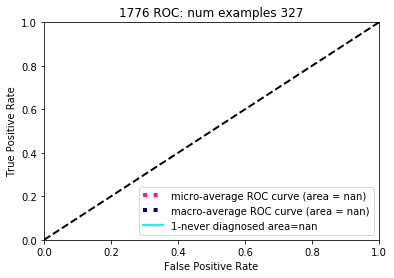

study c879ac8f-a8ee-4f40-b665-7faef159746c 153/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 300, 301)     0           embedding_2[0][0]                
                                                          

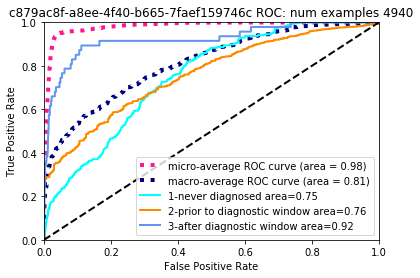

study 567 154/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 300, 301)     0           embedding_3[0][0]                
                                                                 aux_input[0][0]           

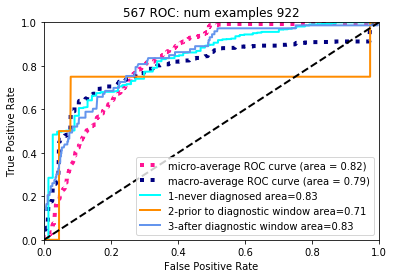

study 565 155/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 300, 301)     0           embedding_4[0][0]                
                                                                 aux_input[0][0]           

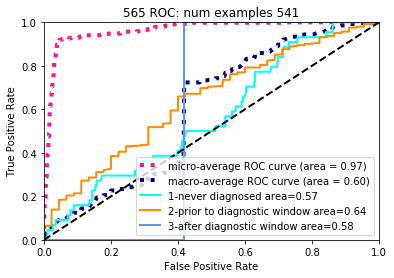

study 1150 156/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 300, 301)     0           embedding_5[0][0]                
                                                                 aux_input[0][0]          

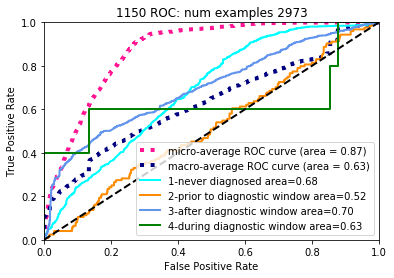

study 625 157/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 300, 301)     0           embedding_6[0][0]                
                                                                 aux_input[0][0]           

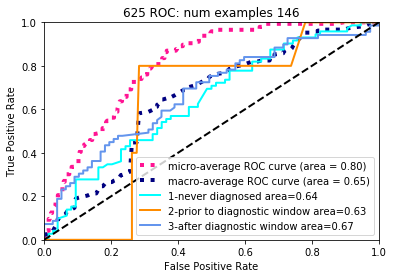

study 4e278045-23d2-46e7-9c39-748b9600d694 158/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 300, 301)     0           embedding_7[0][0]                
                                                          

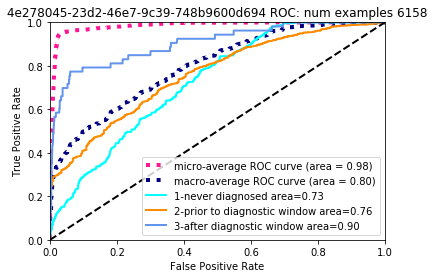

study 1913 159/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_15 (Concatenate)    (None, 300, 301)     0           embedding_8[0][0]                
                                                                 aux_input[0][0]          

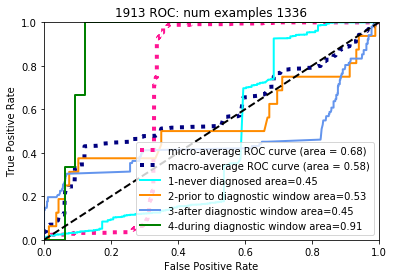

study 11013 160/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_17 (Concatenate)    (None, 300, 301)     0           embedding_9[0][0]                
                                                                 aux_input[0][0]         

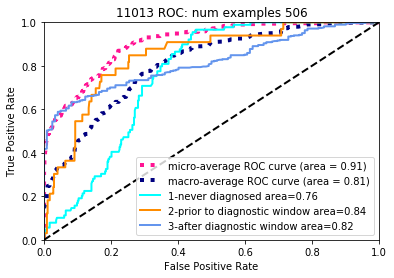

study 829 161/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_19 (Concatenate)    (None, 300, 301)     0           embedding_10[0][0]               
                                                                 aux_input[0][0]           

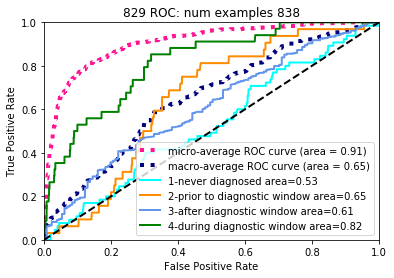

study 506 162/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_21 (Concatenate)    (None, 300, 301)     0           embedding_11[0][0]               
                                                                 aux_input[0][0]           

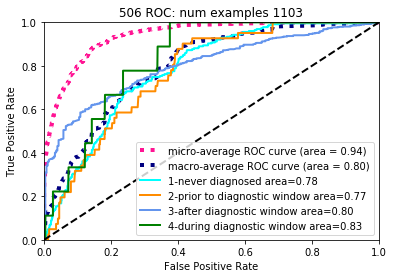

study 1914 163/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_23 (Concatenate)    (None, 300, 301)     0           embedding_12[0][0]               
                                                                 aux_input[0][0]          

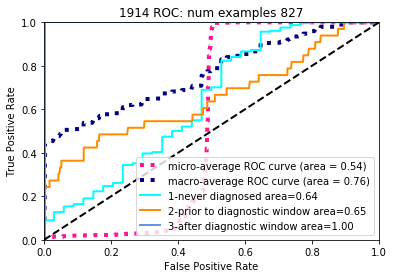

study 7587 164/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_25 (Concatenate)    (None, 300, 301)     0           embedding_13[0][0]               
                                                                 aux_input[0][0]          

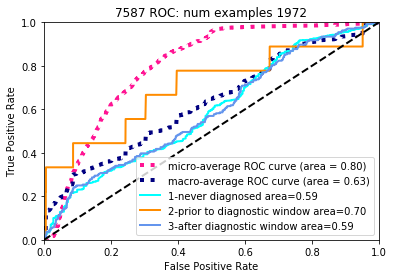

study 396 165/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_27 (Concatenate)    (None, 300, 301)     0           embedding_14[0][0]               
                                                                 aux_input[0][0]           

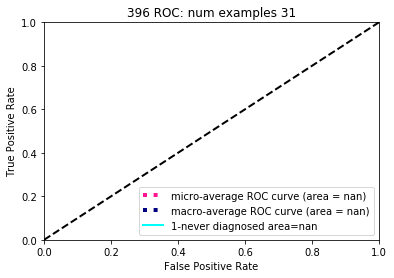

study 518 166/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_29 (Concatenate)    (None, 300, 301)     0           embedding_15[0][0]               
                                                                 aux_input[0][0]           

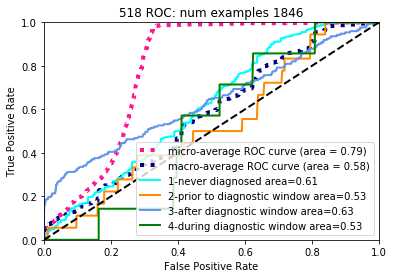

study 1760 167/168
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 300, 300)     21400200    main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 300, 1)       0                                            
__________________________________________________________________________________________________
concatenate_31 (Concatenate)    (None, 300, 301)     0           embedding_16[0][0]               
                                                                 aux_input[0][0]          

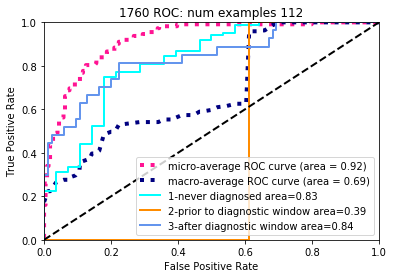

In [7]:
from livelossplot import PlotLossesKeras
from sklearn.metrics import roc_curve, auc
from scipy import interp
import json
import os.path
import random




study_rocuac={} # study per-class rocauc scores
study_indices={} # studyid -> y_pred/y_true indices
study_training_hx={} # studyid -> keras training history
y_pred_cum=np.zeros((0,4),dtype=dtype)
y_true_cum=np.zeros((0,4),dtype=dtype)
study_counter=0

# detect if we are resuming
if os.path.isfile('%s/heldout_disease_roc_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,dataset,model_name)):
    # we are resuming, restore state
    
    # per study roc results
    with open('%s/heldout_disease_roc_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,dataset,model_name), 'r') as file:
        study_rocuac=json.load(file)
    
    # dev pred/test indices in y_true/y_pred for each study
    with open('%s/study_sentence_dictionary_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,dataset,model_name), 'r') as file:
        study_indices=json.load(file)


    # cumulative y_true results for each study so far. study_indices tells you indices for each study
    y_true_cum=np.load('%s/heldout_disease_y_true_cum_%s_dataset_%s_model_%s.npy' % (results_folder,experiment,dataset,model_name))

    # cumulative y_pred results for each study. study_indices tells you indices for each study
    y_pred_cum=np.load('%s/heldout_disease_y_pred_cum_%s_dataset_%s_model_%s.npy' % (results_folder,experiment,dataset,model_name))

    # keras training history of each study
    with open('%s/heldout_disease_training_hx_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,'train',model_name), 'r') as file:
        study_training_hx=json.load(file)
    study_counter=len(study_rocuac)

# loop studies randomly, training and eval as we go
shuffled=list(study_sentence_dictionary_train.items())
random.shuffle(shuffled)

print('loaded persisted results for %s studies' % len(study_rocuac))

for studyid,index_keep_train in shuffled:   

    
    if studyid in study_rocuac:
        continue
        
    print('study %s %s/%s' % (studyid,study_counter,len(study_sentence_dictionary_train)))
    study_counter+=1
    
    # create a training set that doesnt have study in it
    x_train_study,x_train_2_study,y_train_study=(
        np.delete(x_train,index_keep_train,axis=0).astype(dtype)
        ,np.delete(x_train_2,index_keep_train,axis=0).astype(dtype)
        ,np.delete(y_train,index_keep_train,axis=0).astype(dtype)
    )
    
    # create an eval set that only has study in it
    
    # first take all the examples from the training set
    x_dev_study=x_train[index_keep_train,:]
    x_dev_2_study=x_train_2[index_keep_train,:]
    y_dev_study=y_train[index_keep_train,:]
    
    # then append the dev examples if there are any
    if studyid in study_sentence_dictionary_dev:
        # then append the study examples in the training set to the dev set
        index_keep_dev=study_sentence_dictionary_dev[studyid]
        x_dev_study=np.concatenate([x_dev_study,x_dev[index_keep_dev,:] ]).astype(dtype)
        x_dev_2_study=np.concatenate([x_dev_2_study,x_dev_2[index_keep_dev,:]]).astype(dtype)
        y_dev_study=np.concatenate([y_dev_study,y_dev[index_keep_dev,:]]).astype(dtype)

      
  
    
    #create new model
    cpu_model,model,embedding_layer=make_model_2(
        x_train,x_train_2,y_train
        , sg
        , dropout_prob=0.2
        , hidden_dims=80
        , num_filters=100)
    
    # train
    hx=model.fit([x_train_study,x_train_2_study],y_train_study
          ,batch_size=256
          ,validation_data=([x_dev_study,x_dev_2_study],y_dev_study)
          #,callbacks=[PlotLossesKeras()]
          ,epochs=1
          ,verbose=2
          )
    

    study_training_hx[studyid]=hx.history
    
    # eval
    y_pred=cpu_model.predict([x_dev_study,x_dev_2_study]) # note use CPU based model to predict.  The GPU model frequently errors on CUDA for some reason..
    y_true=y_dev_study
    roc_auc=evaluate(y_true,y_pred,plot=True,title='%s ROC: num examples %s' % (studyid,y_true.shape[0]))

    # store results
    study_rocuac[studyid]=roc_auc
    
    # calc indices of this study
    current_index=y_pred_cum.shape[0]
    number_of_predictions=y_pred.shape[0]
    study_indices[studyid]=list(range(current_index,current_index+number_of_predictions))
    
    # store true and predictions
    y_pred_cum=np.concatenate([y_pred_cum,y_pred],axis=0)
    y_true_cum=np.concatenate([y_true_cum,y_true],axis=0)

    
    # persist results so far
    with open('%s/heldout_disease_roc_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,dataset,model_name), 'w') as file:
        json.dump(study_rocuac, file)
    with open('%s/study_sentence_dictionary_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,dataset,model_name), 'w') as file:
        json.dump(study_indices, file)
    np.save('%s/heldout_disease_y_true_cum_%s_dataset_%s_model_%s.npy' % (results_folder,experiment,dataset,model_name),y_true_cum)
    np.save('%s/heldout_disease_y_pred_cum_%s_dataset_%s_model_%s.npy' % (results_folder,experiment,dataset,model_name),y_pred_cum)
    
    with open('%s/heldout_disease_training_hx_exp_%s_dataset_%s_model_%s.json' % (results_folder,experiment,'train',model_name), 'w') as file:
        json.dump(study_training_hx, file)
        
    
    

# overall ROC curves

/home/noel/tensorflow/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


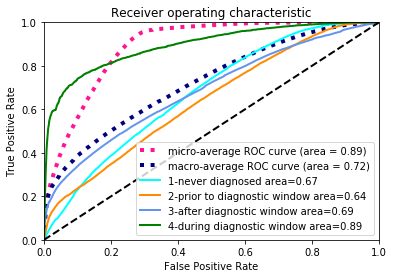

168


In [9]:
evaluate(y_true_cum, y_pred_cum)
print(len(study_rocuac))
